In [1]:
import h5py, os, sys
sys.path.append('../lib')

Fatal Python error: Py_Initialize: Unable to get the locale encoding
ModuleNotFoundError: No module named 'encodings'

Current thread 0x00007f3a54033740 (most recent call first):


In [3]:
import numpy as np


import matplotlib.pyplot as plt
import matplotlib

import ROOT as rt

from histo_utilities import create_TH2D, create_TH1D, create_Canvas, make_effiency_plot, rootTH1_to_np

import scipy as sp
import scipy.stats


def HypotesisTets(h_a, h_r, eff, N_asymov = 100000, show_hist = False):
    aux, _ = rootTH1_to_np(h_r)
    nu = eff*aux/(1-eff)
    
    o_asymov = np.random.poisson(nu, (N_asymov, nu.shape[0]))
    
    probs = sp.stats.poisson.pmf(o_asymov, nu)
    nll = -np.log(probs)
    s_asymov = np.sum(nll, axis=-1)
    
    aux, _ = rootTH1_to_np(h_a)
    probs_obs = sp.stats.poisson.pmf(aux.astype(np.int), nu)
    s_obs = np.sum(-np.log(probs_obs), axis=-1)
    
    p_val = np.sum(s_asymov > s_obs)/float(N_asymov)
    
    
    if show_hist:
        plt.hist(s_asymov)

    return p_val

Welcome to JupyROOT 6.20/06


In [4]:
f = h5py.File('/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/run_106/qcd_sqrtshatTeV_13TeV_PU40_reco.h5', 'r')
print(f.keys())
print(list(f.get("eventFeatureNames")))
print(len(f.get("eventFeatures")))

[u'eventFeatureNames', u'eventFeatures']
['mJJ', 'j1Pt', 'j1Eta', 'j1Phi', 'j1M', 'j1E', 'j2Pt', 'j2M', 'j2E', 'DeltaEtaJJ', 'DeltaPhiJJ', 'j1TotalLoss', 'j1RecoLoss', 'j1KlLoss', 'j2TotalLoss', 'j2RecoLoss', 'j2KlLoss', 'sel_q90', 'sel_q50', 'sel_q10', 'sel_q01']
800000



 quantile = 100-0.1
Total = 800000
Pass = 85120
Fail = 714880


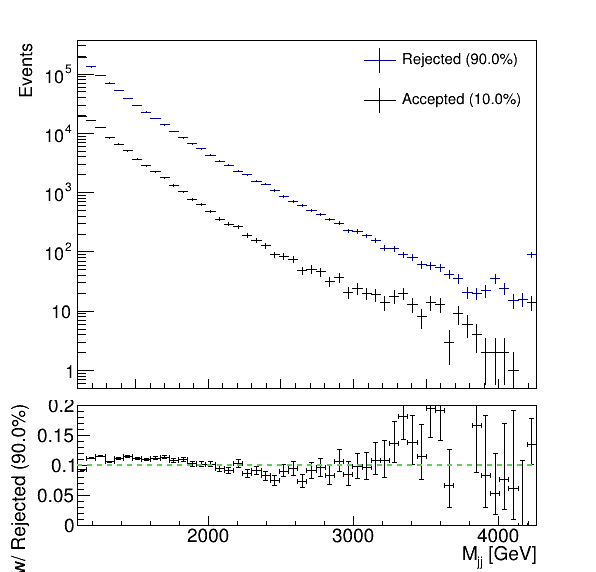

In [5]:
Mjj_selection = 1100.


quantiles = [0.90,0.50,0.10,0.01]
columns   = [17  ,18  ,19  ,20] 

q = 0.1
c = 19


#for c,q in zip(columns,quantiles):

SM_eff = q
data = np.array(f.get("eventFeatures"))
data_pass = data[data[:,c] == 1]
data_fail = data[data[:,c] == 0] 

x = np.reshape(data[:,0], (-1,1))
binning=[50, Mjj_selection, np.quantile(x, 0.9999)]

print('\n quantile = 100-{}'.format(q))
print('Total = {}'.format(data.shape[0]))
print('Pass = {}'.format(data_pass.shape[0]))
print('Fail = {}'.format(data_fail.shape[0]))

h_a = create_TH1D(data_pass[:,0], 
                  name='h_acc', title='Accepted ({}%)'.format(q*100),
                  binning=binning,
                  opt='overflow'
                 )
h_a.SetLineColor(1)
h_a.SetStats(0)
h_a.Sumw2()
h_r = create_TH1D(data_fail[:,0], 
                  name='h_rej', title='Rejected ({}%)'.format((1-q)*100),
                  axis_title=['M_{jj} [GeV]', 'Events'],
                  binning=binning,
                  opt='overflow'
                 )
ymax = 2.0*h_a.GetMaximum() if h_a.GetMaximum()>h_r.GetMaximum() else 2.0*h_r.GetMaximum()
h_r.GetYaxis().SetRangeUser(0.5,ymax )
h_r.SetStats(0)
h_r.Sumw2()

c = make_effiency_plot([h_r, h_a], ratio_bounds=[SM_eff-SM_eff, SM_eff+SM_eff], draw_opt = 'E')
c.pad1.SetLogy()
# c.pad2.SetLogy()

c.pad2.cd()
ln = rt.TLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)
ln.SetLineWidth(2)
ln.SetLineStyle(7)
ln.SetLineColor(8)
ln.DrawLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)

c.Draw()

0.0


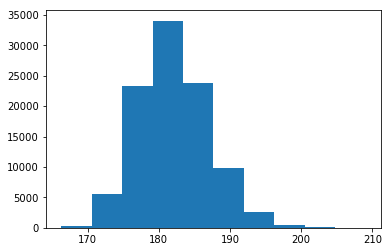

In [6]:
aux, _ = rootTH1_to_np(h_r)

nu = SM_eff*aux/(1-SM_eff)
   
N_asymov = 100000
o_asymov = np.random.poisson(nu, (N_asymov, nu.shape[0])) 
probs = sp.stats.poisson.pmf(o_asymov, nu)
nll = -np.log(probs)
s_asymov = np.sum(nll, axis=-1)
    
aux, _ = rootTH1_to_np(h_a)
probs_obs = sp.stats.poisson.pmf(aux.astype(np.int), nu)
s_obs = np.sum(-np.log(probs_obs), axis=-1)
    
p_val = np.sum(s_asymov > s_obs)/float(N_asymov)
    
plt.hist(s_asymov)
print(p_val)

In [7]:
binning=[30, Mjj_selection, 2000.0]
print(binning)

# scale factor to scale signal
scale = q

# histogram dictionary
histos = {}

datacard_hist = rt.TFile.Open('datacard_hist.root','recreate')
datacard_ws = rt.TFile.Open('datacard_ws.root','recreate')
w = rt.RooWorkspace('w','w')
x = rt.RooRealVar('x','x',binning[1],binning[2])
w.factory('x[%.1f,%.1f]'%(binning[1],binning[2]))
w.factory('p1[4.1]')
w.factory('p2[7.9]')
w.factory('p3[0.6]')
w.factory('p4[0.025]')
w.factory('sqrts[13000]')
w.factory('qcd_tot_norm[1.]')
w.factory('qcd_bin_tot_norm[1.]')
# CMS 5-parameter
w.factory("EXPR::qcd_tot('max(0.,pow(1-x/sqrts,p1)/pow(x/sqrts,p2+p3*log(x/sqrts)+p4*log(x/sqrts)*log(x/sqrts)))',x,p1,p2,p3,p4,sqrts)")
# ATLAS 5-parameter
#w.factory("EXPR::qcd_tot('max(0.,exp(-p2*(x/sqrts)-p3*pow(x/sqrts,2)-p4*pow(x/sqrts,3))/pow(x/sqrts,p1))',x,p1,p2,p3,p4,sqrts)")

w.var('sqrts').setConstant(True)
w.var('p1').setConstant(False)
w.var('p2').setConstant(False)
w.var('p3').setConstant(False)
w.var('p4').setConstant(False)
w.var('qcd_tot_norm').setConstant(False)
w.var('qcd_bin_tot_norm').setConstant(False)
roolist = rt.RooArgList()
roolist.add(w.var('p1'))
roolist.add(w.var('p2'))
roolist.add(w.var('p3'))
roolist.add(w.var('p4'))
roolist.add(w.var('sqrts'))
empty_hist = rt.TH1D('empty_hist','empy_hist',binning[0],binning[1],binning[2])
qcd_bin_tot = rt.RooParametricShapeBinPdf('qcd_bin_tot', 
                                          'qcd_bin_tot', 
                                          w.pdf('qcd_tot'), 
                                          w.var('x'), 
                                          roolist, 
                                          empty_hist)
getattr(w,'import')(qcd_bin_tot, rt.RooCmdArg())

h_t = create_TH1D(data[:,0], 
                  name='h_tot', title='Total',
                  binning=binning,
                  opt=''
                 )
h_t.SetLineColor(rt.kGreen)
h_t.SetStats(0)
h_t.Sumw2()

w.factory('eqcd_tot_norm[%.1f]'%h_t.Integral())
w.factory("SUM::eqcd_tot(eqcd_tot_norm*qcd_tot)")
w.factory("SUM::eqcd_bin_tot(eqcd_tot_norm*qcd_bin_tot)")
w.var('eqcd_tot_norm').setConstant(False)

h_a = create_TH1D(data_pass[:,0], 
                  name='h_acc', title='Accepted',
                  binning=binning,
                  opt=''
                 )
h_a.SetLineColor(rt.kGreen)
h_a.SetStats(0)
h_a.Sumw2()
h_r = create_TH1D(data_fail[:,0], 
                  name='h_rej', title='Rejected',
                  axis_title=['M_{jj} [GeV]', 'Events'],
                  binning=binning,
                  opt=''
                 )
h_r.SetLineColor(rt.kGreen)
h_r.GetYaxis().SetRangeUser(0.5, 1.2*h_r.GetMaximum())
h_r.SetStats(0)
h_r.Sumw2()

histos['qcd_tot'] = h_t
histos['qcd_acc'] = h_a
histos['qcd_rej'] = h_r
histos['data_obs_tot'] = h_t
histos['data_obs_acc'] = h_a
histos['data_obs_rej'] = h_r
h_t.SetDirectory(0)
h_a.SetDirectory(0)
h_r.SetDirectory(0)

acc_bin_functions = rt.RooArgList()
rej_bin_functions = rt.RooArgList()
w.factory('eff[%f,0,1]'%(h_a.Integral()/h_r.Integral()))
w.var('eff').setConstant(False)
for iBinX in range(1,binning[0]+1):
    w.factory('crBin%i_In[%.1f]'%(iBinX,h_r.GetBinContent(iBinX)))
    w.factory('crBin%i[0,-100,100]'%(iBinX))
    w.var('crBin%i_In'%iBinX).setConstant(True)
    w.var('crBin%i'%iBinX).setConstant(False)
    w.factory("expr::crBin%iFunc('max(0,@0*pow(1.0+%f,@1))',crBin%i_In,crBin%i)"%(iBinX,1/rt.TMath.Sqrt(h_r.GetBinContent(iBinX)),iBinX,iBinX))
    w.factory("expr::bin%iFunc('max(0,@0*@1)',eff,crBin%iFunc)"%(iBinX,iBinX))
    rej_bin_functions.add(w.function('crBin%iFunc'%iBinX))
    acc_bin_functions.add(w.function('bin%iFunc'%iBinX))
    
qcd_rph_rej = rt.RooParametricHist('qcd_rph_rej','qcd_rej_acc',w.var('x'),rej_bin_functions,empty_hist)
qcd_rph_rej_norm = rt.RooAddition('qcd_rph_rej_norm','qcd_rph_rej_norm',rej_bin_functions)
qcd_rph_acc = rt.RooParametricHist('qcd_rph_acc','qcd_rph_acc',w.var('x'),acc_bin_functions,empty_hist)
qcd_rph_acc_norm = rt.RooAddition('qcd_rph_acc_norm','qcd_rph_acc_norm',acc_bin_functions)
getattr(w,'import')(qcd_rph_rej, rt.RooCmdArg())
getattr(w,'import')(qcd_rph_rej_norm, rt.RooFit.RecycleConflictNodes())
getattr(w,'import')(qcd_rph_acc, rt.RooCmdArg())
getattr(w,'import')(qcd_rph_acc_norm, rt.RooFit.RecycleConflictNodes())


[30, 1100.0, 2000.0]


AttributeError: RooParametricShapeBinPdf


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [ ]:


for name_BSM in ['GtoWW']:
    print('\n'+name_BSM)
    
    
    h_t_BSM = create_TH1D(data[name_BSM]['mJJ'], 
                  name='h_t'+name_BSM,
                  binning=h_t.binning,
                  opt=''
                 )
    h_t_BSM.SetLineColor(rt.kBlue)
    h_t_BSM.Sumw2()
    h_t_BSM.Scale(scale)
    
    h_a_BSM = create_TH1D(data[name_BSM]['mJJ'][data[name_BSM]['sel']], 
                  name='h_a'+name_BSM,
                  binning=h_a.binning,
                  opt=''
                 )
    h_a_BSM.SetLineColor(rt.kBlue)
    h_a_BSM.Sumw2()
    h_a_BSM.Scale(scale)
    
    h_r_BSM = create_TH1D(data[name_BSM]['mJJ'][np.logical_not(data[name_BSM]['sel'])], 
                  name='h_r'+name_BSM,
                  binning=h_r.binning,
                  opt=''
                 )
    h_r_BSM.SetLineColor(rt.kBlue)
    h_r_BSM.Sumw2()
    h_r_BSM.Scale(scale)

    
    c_t = rt.TCanvas('c_t','c_t',500,400)
    h_t.Draw()
    h_t.SetMinimum(1)
    h_t_BSM.Draw('same')
    c_t.SetLogy()
    c_t.Draw()
    
    c_a = rt.TCanvas('c_a','c_a',500,400)
    h_a.Draw()
    h_a_BSM.Draw('same')
    c_a.SetLogy()
    c_a.Draw()
    
    c_r = rt.TCanvas('c_r','c_r',500,400)
    h_r.Draw()
    h_r_BSM.Draw('same')
    c_r.SetLogy()
    c_r.Draw()
    
    datacard_hist.cd()
    histos[name_BSM+'_tot'] = h_t_BSM
    histos[name_BSM+'_acc'] = h_a_BSM
    histos[name_BSM+'_rej'] = h_r_BSM
    h_t_BSM.SetDirectory(0)
    h_a_BSM.SetDirectory(0)
    h_r_BSM.SetDirectory(0)


for key, histo in histos.iteritems():
    datacard_hist.cd()
    histo.Write(key)
    if 'qcd' not in key:
        ds = rt.RooDataHist(key,key,rt.RooArgList(w.var('x')),histo)
        getattr(w,'import')(ds, rt.RooCmdArg())


nll = w.pdf('eqcd_tot').createNLL(w.data('data_obs_tot'))
m2 = rt.RooMinimizer(nll)
m2.setStrategy(2)
m2.setMaxFunctionCalls(100000)
m2.setMaxIterations(100000)
m2.setPrintLevel(-1)
m2.setPrintEvalErrors(-1)
m2.setEps(1e-5)
m2.optimizeConst(2)
migrad_status = m2.minimize('Minuit2', 'migrad')
improve_status = m2.minimize('Minuit2', 'improve')
hesse_status = m2.minimize('Minuit2', 'hesse')
fr = m2.save()

fr.Print('v')

datacard_ws.cd()
w.Write()
datacard_hist.Close()
datacard_ws.Close()


c_frame = rt.TCanvas('c_frame','c_frame',500,400)
frame = w.var('x').frame()
w.data('data_obs_tot').plotOn(frame)
w.pdf('eqcd_tot').plotOn(frame)
frame.Draw()
c_frame.Draw()
c_frame.SetLogy()

w.Print('v')